# Experimental environment setup

## Library preparation

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


In [3]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *
from qcodes.instrument_drivers.tektronix.AWG5204_Isrc import AWG5204_Isrc

In [4]:
# #This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

# import time, os
# dir_path = os.getcwd()
# pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,time.localtime()[1],time.localtime()[2],time.localtime()[3],time.localtime()[4],time.localtime()[5])

# from PIL import ImageGrab
# img = ImageGrab.grabclipboard()
# img.save(pngpath, 'PNG')

# from IPython.display import Image, display
# display(Image(filename=pngpath))

# import clipboard
# clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))

In [5]:
# display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\measDC\55B1_revist 1D chain\img\19113-124446.png'))

## Instrument nicknames and QC database initialization

In [6]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr
Bfield =  Flux_chA
Bfield.step = .1e-3
Bfield.inter_delay = .1

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

# htr = LS370.sample_heater
htr = LS370htr()
htr.Tset(0.030)
htr.PIDset(30,5,1)
htr.HTRset('off')

# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)
Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
Isrc.init()

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

station = qc.Station(Isrc, Vmeter)

print ('Instrument initialization completed.')

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.48s
Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.10s
initialization \\JOSH-PC\Gersh_Labview\DC measurement\LSCI 370 PYTHON_conf.vi
Instrument initialization completed.


## Fridge handling log

In [7]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

T8.get()

14.748

Fri Nov  22 13:05:00 2019
	Collect mixture and warm up
	T[1,2,5,6,8]:	[54.1, 3.86, 0.9, 0.96, 0.98]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 12:25:00 2019
	Start Condense_wLN2
	Flow = 0.00, 	Still = 0%

Fri Nov  22 10:55:00 2019
	Start Pulse_PreCool @T8 = 13K
	T[1,2,5,6,8]:	[55.9, 5.0, 7.1, 9.8, 13]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 10:55:00 2019
	Start Pulse_PreCool @T8 = 13K
	T[1,2,5,6,8]:	[55.9, 5.0, 7.1, 9.8, 13]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 08:55:00 2019
	Start Pulse_PreCool @T8 = 11.56K
	T[1,2,5,6,8]:	[49.6, 4.3, 5.0, 6.5, 8.9]
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	ON PT @P1 = 2.30E-3. ON HS-STILL, HS-MC
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 21:20:00 2019
	ON Turbo @P1 = 3.0E-3
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	User: wsLu. Sample: Q1D074, SiOx002. Roughing
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%



## Scripts

### Measurement scripts

In [8]:
def uduFF_list(amp1=240e-12, amp2=2000e-12, stp1=2e-12, stp2=80e-12):

    i_list_uf = np.linspace(0, amp1, round (amp1/stp1) + 1)
    i_list_uc = np.linspace(amp1, amp2, round ((amp2-amp1)/stp2) + 1)
    i_list = np.append(i_list_uf, i_list_uc)

    i_list_d = [np.linspace(amp2, amp1, round ((amp2-amp1)/stp2) + 1),
                np.linspace(amp1, 0, round (amp1/stp1) + 1),
                np.linspace(0, -1*amp1, round (amp1/stp1) + 1),
                np.linspace(-1*amp1, -1*amp2, round ((amp2-amp1)/stp2) + 1)]
    for lst in i_list_d:
        i_list = np.append(i_list, lst)

    i_list_ucn = np.linspace(-1*amp2, -1*amp1, round ((amp2-amp1)/stp2) + 1)
    i_list_ufn = np.linspace(-1*amp1, 0, round (amp1/stp1) + 1)
    i_list = np.append(i_list, i_list_ucn)
    i_list = np.append(i_list, i_list_ufn)

    return i_list

In [9]:
def setup():
    Isrc.I.set(0)

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)

In [213]:
def IVC_udu (amp, stp, Gain, R_bias, Attn, tfsstb = 0.1):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)

    name_exp(sample = SAMPLE, exp_type = 'IVc @T={}K, B={}A'.format(si_format(T8.get()), si_format(Bfield.get(), precision = 3)))
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(tfsstb)
            V = Vmeter.V.get()

            res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
            datasaver.add_result(*res) 

    cleanup()
    return datasaver.run_id 

In [134]:
def Bperiod_meas (amp=1e-9, Gain=100, R_bias=1e9, Attn=1, B_list = [0]):

    meas = set_meas(Vmeter.V, Bfield, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    tB_list = tqdm_notebook(B_list)

    name_exp(sample = SAMPLE, exp_type = 'B periodicity @T={}K, Ib={}A'.format(si_format(T8.get()), si_format(amp, precision=0)))
    with meas.run() as datasaver:

        for B in tB_list:

            Bfield.set(B)
            time.sleep(0.5)
            Isrc.I.set( 1*amp)
            Vp = Vmeter.V.get()
            Isrc.I.set(-1*amp)
            Vn = Vmeter.V.get()
            delV = Vp-Vn
            volt = [( Bfield, B ), ( Vmeter.V, delV )]

            datasaver.add_result(*volt) 

    cleanup()
    return datasaver.run_id 

In [210]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn, tfsstb = 0.1):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(tfsstb)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

                res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [211]:
def IVcB_meas (i_list, B_list, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    i_lists = [i_list]
    
    meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
    tB_list = tqdm_notebook(B_list)
    for B in tB_list:

        name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision =3)))
        with meas.run() as datasaver:

            Bfield.set(B)
            for i_list in i_lists:

                Isrc.I.set(0)
                V_ = Vmeter.V.get()
                time.sleep(1)

                for i in i_list:

                    Isrc.I.set(i)
                    time.sleep(tfsstb)

                    V = Vmeter.V.get()
                    dV = V - V_
                    V_ = V

                    if  (abs(V) > 6.4e-3) : #(abs(dV) > thr)  or
                        break

                    res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                    datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [212]:
# adaptive step size with while loop
def IVcB_ada(npts_B = 51, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):
    ZF =  0.004e-3
    FF =  0.224e-3
    dF =  0.250e-3
    midF = 0.154e-3

#     maxI = 40e-9
#     step_ff = 2e-12
#     step_f = 10e-12
#     step_c = 200e-12
#     maxI    = 300e-9
#     step_ff = 200e-12
#     step_f  = 200e-12
#     step_c  =   4e-9
    maxI    = 300e-12
    step_ff =   2e-12
    step_f  =  10e-12
    step_c  =  50e-12
    
    thr = thr

    B_list = np.linspace(ZF, ZF + 1.0*dF, npts_B)
    tB_list = tqdm_notebook(B_list)

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    for B in tB_list:
        meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

        name_exp(sample = SAMPLE, exp_type = 'Bscan IVC @T ={:2.1f}mK, B = {}A'.format(T8.get()/1e-3, si_format(B)) )  
        with meas.run() as datasaver:

                Bfield.set(B)

                for pm in [1, -1]:

                    i = 22.5*1e-3/R_bias

                    Isrc.I.set(i)
                    time.sleep(1)
                    V_off = Vmeter.V.get()
                    V_ = V_off
                    time.sleep(1)

                    if B < midF:
                        step = step_f
                    else:
                        step = step_ff

                    while abs(i) < maxI:

                        Isrc.I.set(i)
                        time.sleep(tfsstb)

                        V = Vmeter.V.get()
                        dV = V - V_
                        V_ = V

                        res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]

                        datasaver.add_result(*res) 

                        if (abs(dV) > thr)  or (abs(V - V_off) > thr ) : #
                            step = step_c

                        i += pm*step

    cleanup()
    return datasaver.run_id 

In [85]:
# # Use this code for T-dependent tasks
# # Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
# # setT8_lst = np.linspace(0.050, 0.550, 11) 
# setT8_lst = [.075, .125, .175, .225] 

# tolerT8 = 0.02
# chkrepeat = 20
# chkperiod_sec = 2

# Tnow_alllst = []
# timer_lst = []

# for setT8 in setT8_lst:
# #     htr.setpoint(setT8)
#     htr.Tset(setT8)
#     print('ramping T8 to {}K...'.format(si_format(setT8)))
#     time.sleep(30)
#     Tnow_lst = []

#     t0 = time.time()
#     count_T = 0
#     while count_T < chkrepeat:
#         T_now = T8.get()
#         if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
#             count_T +=1
#             Tnow_lst.append(T_now)
#             time.sleep(chkperiod_sec)
#         elif count_T >= 1 :
#             count_T -=1
#     t1 = time.time()
    
#     timer_lst.append(t1-t0)
#     Tnow_alllst.append(Tnow_lst)

#     IVcB_ada(npts_B = 51, thr=4e-3, Gain=100, R_bias=1e7, Attn=1, tfsstb = 0.1) 
#     # insert here the repeatative work to be done at each T

# # htr.setpoint(0.030)
# htr.Tset(0.030)

In [16]:
def RTc (dataPts = 100, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-9, T_str = 0):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    pts_list = np.arange(1, dataPts)
    tpts_list = tqdm_notebook(pts_list)

    name_exp(sample = SAMPLE, exp_type = 'RTc')
    with meas.run() as datasaver:
        for j in tpts_list:

            Ib_list = udu_list(1*I_bias, 0.5*I_bias)
            V1_list = []
            T8_lst = []
            for Ib in Ib_list:
                Isrc.I.set(Ib)
                time.sleep(tfsstb)
                V1_list = np.append(V1_list, Vmeter.V.get())
                T8_lst.append(T8.get())
            T_now = sum(T8_lst)/len(T8_lst)
            R_now, intercept, r_value, p_value, std_err = stats.linregress(Ib_list, V1_list)
            
            res = [( Isrc.I, T_now ), ( Vmeter.V, R_now )]
            with open('CH0 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(R_now), time.localtime())+'\n')
                fp.close
            with open('CH8 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(T_now), time.localtime())+'\n')
                fp.close

#             print('Current T8= {}K'.format(si_format(T8.get()), end='\r'))
            sys.stdout.write("\rCurrent T8= {}K".format(si_format(T8.get())))
            sys.stdout.flush()
            datasaver.add_result(*res)
            if T_str == 300:
                time.sleep(54.5)
            else:
                time.sleep(0.05)

    cleanup()
    return datasaver.run_id 

### Data processing scripts

In [17]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [18]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

In [19]:
# # Quick visualization of the results

# qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format('70B1N7')
# initialise_database()
# f,ax=plt.subplots()

# label = ['a',
#          'b',
#          'v',
#          'meas on Nov 11th']

# for i,v in enumerate([105, 971,1092,1095]):
#     data = get_data_by_id(v)
#     Is = data[0][0]['data']
#     Vs = data[0][1]['data']
#     ax.plot(Is, Vs, '.', ls='-',label = '{}'.format(label[i]))

# ax.legend()

## Devices

### Device detail

- ID: Q1D074: large JJ chains
 - N3: (7ba,8ba), $R_{RT, 4pb} = 350k\Omega$, this $.7 \times .7 \mu m^2 JJ$ device has $E_J 180mK, E_C 90mK$
 - N4: (6ab,9ba), $R_{RT, 4pb} = 22.3k\Omega$, this $1.5 \times 1.5 \mu m^2 JJ$ device has high $E_J$ to check $E_J(cos(\phi))$ cross-over.
- ID: SiOx002: pure Al on SiOx for $T_C$ characterization
 - N3: (12ba,11b12a), $R_{RT, 4pb} = 52.3\Omega$, $1\mu m$ wide Hall bar. Ch11a was dead right after chamber closed. $R_{3pb}=100.7k\Omega$ doesn't look promising.
 - N4: (1ab,1a2b), $R_{RT, 4pb} = 209\Omega$, $2\mu m$ wide Hall bar
 - N6: (3ab,4ba), $R_{RT, 4pb} = 2.1\Omega$, $10\mu m$ wide Hall bar

- Instrumentation
 - $R_{G, 2pb}$ = OVFL on all devices
 - $R_{coil} = 1.24k\Omega$
 - $R_{therm} = 1.056k\Omega$


- Device scheme for Q1D074
 - Type: 1D chain with 16 SQUIDs, pentagon capacitors with larger spacing to accomodate larger junction area design.
 - Shunting capacitor C0: No Pt yet.
 - C0 area: 
 - SQUID area: 
 - Junction area:
 - Oxidation: 201 torr "wet" oxigen, 15min (by Plamen) (A 20x, ox 140x, w>>2.5um x 2.5um)
 
- Device scheme for SiOx002
 - Typical Hall bar with width ranging from $0.2\mu m - 10\mu m$
 - Pure Al by AC sputtering, thk ranging from $20nm - 50nm$

### Biasing scheme

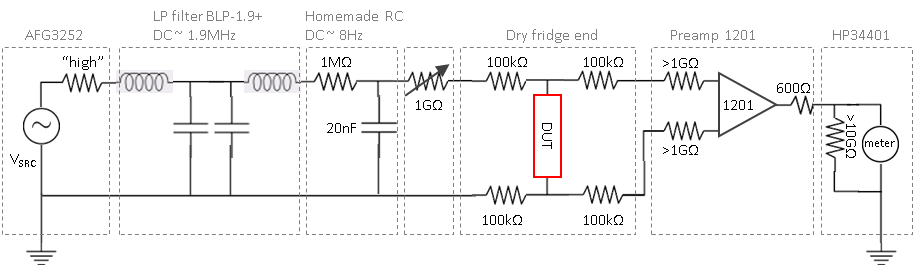

In [20]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\img\191026-183349.png'))

### Device quick overview

**Junction devices parameter**

- D074 site3: 
 - JJparameters(RN= 329e3/ 8, JJwidthUM=np.sqrt( .722 *  .285), metalTHK=250E-10, Tc=1.34) 9.39504
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [41.125, 6.02] (area .7x.172)
 - [I_AB (nA), EJ (mK)] = [7.78019, 185.45678]
 - [C_JJQP (fF), EC (mK)] = [10.2885, 90.35571]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [1.13712]
 - [Q, Beta, EJ/EC] = [136.1, 18516.1, 92.4]

- D074 site4: 
 - JJparameters(RN=21.7e3/ 8, JJwidthUM=np.sqrt( 1.08 *  1.77), metalTHK=250E-10, Tc=1.34) 5.37273
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [2.7125, 5.18] (area 1.62x1.10)
 - [I_AB (nA), EJ (mK)] = [117.95769, 2811.76414]
 - [C_JJQP (fF), EC (mK)] = [95.58, 9.72614]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [4.42765]
 - [Q, Beta, EJ/EC] = [34.9, 1221.3, 1400.7]

## Measurement

### List of run_ids

In [ ]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

pd.set_option("display.precision", 3)

In [ ]:
# keys  = [                  'ids',    'T',      'B',                                      'Vthr']
# valss = [[              [8,9,10],     43e-3,    [ZF,midF,FF],                             4e-3],
#          [                  [13],     43e-3,    udu_list(amp=0.500e-3, stp=0.005e-3) ,    4e-3],
#          [range(  22,   42+1)[:],     50e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range(  43,   63+1)[:],    100e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range(  64,   84+1)[:],    150e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range(  85,  105+1)[:],    200e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range( 106,  126+1)[:],    250e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range( 127,  147+1)[:],    300e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range( 148,  168+1)[:],    350e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range( 169,  189+1)[:],    400e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range( 190,  210+1)[:],    450e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#          [range( 211,  231+1)[:],    500e-3,    np.linspace(ZF, ZF + 1.0*dF, 21) ,        4e-3],
#         ]  

# exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]

In [241]:
SAMPLE = '74N3' #7ba,8ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [3],  45e-3, np.array([ZF])                      ,   4e-3, 'quick IVc meas'  ],
       [            [15,16,17],  45e-3, np.array([ZF,midF,FF])              ,   4e-3, 'quick IVc meas'  ]]
        
ex74N3 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

In [265]:
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[              [8,9,10],  43e-3, np.array([ZF,midF,FF])              ,   4e-3, 'quick IVc meas'  ],  
       [                  [13],  43e-3, udu_list(amp=0.500e-3, stp=0.005e-3),   4e-3, ''                ],  
       [range(  22,   42+1)[:],  50e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  43,   63+1)[:], 100e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  64,   84+1)[:], 150e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  85,  105+1)[:], 200e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 106,  126+1)[:], 250e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 127,  147+1)[:], 300e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 148,  168+1)[:], 350e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 169,  189+1)[:], 400e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 190,  210+1)[:], 450e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 211,  231+1)[:], 500e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 232,  252+1)[:], 550e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 253,  262+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc_ada'],  
#        [range( 263,  272+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],  
       [range( 273,  282+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],    
       [range( 286,  336+1)[:],  43e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at Tbase'   ],    
       [range( 337,  387+1)[:],  75e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at  75mK'   ],    
       [range( 388,  438+1)[:], 125e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 125mK'   ],    
       [range( 439,  489+1)[:], 175e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 175mK'   ],    
       [range( 490,  540+1)[:], 225e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 225mK'   ],    
       [         [541,542,543],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB,  no attn'  ],    
       [         [544,545,546],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB, 10x attn'  ]]

ex74N4 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

### Plans and list of ToDo-es

**Plan**
- Meas $T_C$ for pure Al HB: O2N4($2\mu m$), O2N6($10\mu m$). O2N3 probably can't get SC state by all means.
- Meas $I_C$ for 74N3


**Selected meas to be done**
- 
- 

## Experiments

In [52]:
# B_list = np.linspace( 0, 0.500e-3, 501)
B_list = udu_list(amp=0.500e-3, stp=0.005e-3)
Bperiod_meas (amp=100e-9, Gain=100, R_bias=1e7, Attn=1, B_list = B_list)

Starting experimental run with id: 13



13

In [200]:
for B in [ZF,midF,FF]:
    Bfield.set(B)
#     IVC_udu (amp = 300e-12, stp = 2e-12, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1) #74N3 7ba,8ba standard IVc
#     IVC_udu (amp=200e-9, stp=2e-9, Gain=100, R_bias=1e7, Attn=1, tfsstb = 0.1) #74N4, 6ab,9ba standard IVc
    IVC_udu (amp=200e-9, stp=2e-9, Gain=100, R_bias=1.2e6, Attn=10, tfsstb = 0.1) #74N4, 6ab,9ba IVc with attn

#     IVC_udu (amp=4e-9, stp=40e-12, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1)
#     IVcB_ada(npts_B = 1, thr=4e-3, Gain=100, R_bias=1e7, Attn=1, tfsstb = 0.1)
Bfield.set(0)

Starting experimental run with id: 544



Starting experimental run with id: 545



Starting experimental run with id: 546



In [123]:
IVcB_ada(npts_B = 3, thr=4e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1)
# IVcB_ada(npts_B = 3, thr=4e-3, Gain=100, R_bias=1e7, Attn=1, tfsstb = 0.1)

Starting experimental run with id: 9
Starting experimental run with id: 10
Starting experimental run with id: 11



11

In [138]:
RTc(dataPts = 1e5, Gain = 100, R_bias = 2.2e6, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-6, T_str = 0)

In [ ]:
# Use this code for T-dependent tasks
# Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
# setT8_lst = np.linspace(0.050, 0.550, 11) 
setT8_lst = [.075, .125, .175, .225] 

tolerT8 = 0.02
chkrepeat = 20
chkperiod_sec = 2

Tnow_alllst = []
timer_lst = []

for setT8 in setT8_lst:
#     htr.setpoint(setT8)
    htr.Tset(setT8)
    print('ramping T8 to {}K...'.format(si_format(setT8)))
    time.sleep(30)
    Tnow_lst = []

    t0 = time.time()
    count_T = 0
    while count_T < chkrepeat:
        T_now = T8.get()
        if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
            count_T +=1
            Tnow_lst.append(T_now)
            time.sleep(chkperiod_sec)
        elif count_T >= 1 :
            count_T -=1
    t1 = time.time()
    
    timer_lst.append(t1-t0)
    Tnow_alllst.append(Tnow_lst)

    IVcB_ada(npts_B = 51, thr=4e-3, Gain=100, R_bias=1e7, Attn=1, tfsstb = 0.1) 
    # insert here the repeatative work to be done at each T

# htr.setpoint(0.030)
htr.Tset(0.030)

## Key observations

### pure Al Hall bar

<IPython.core.display.Javascript object>


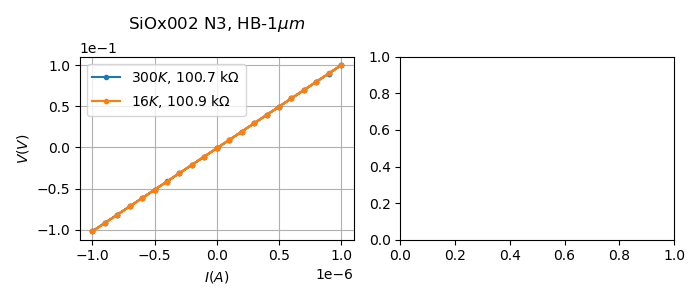

In [262]:
SAMPLE = 'O2N3' #12ba,11b12a
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 1.51e-6, 17.9e-6, 40e-9

#'$1\mu A$', runid=2, before ch11b was dead
labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([6,7]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('SiOx002 N3, HB-$1\mu m$', pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


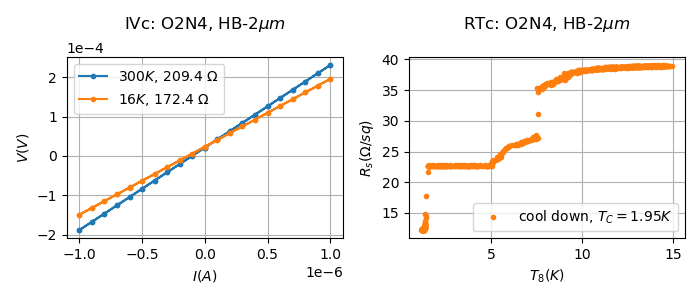

In [261]:
SAMPLE = 'O2N4' #1ab,1a2b
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 3.06e-6, 12.2e-6, 48e-9

labelL = ['$300K$',#8
          '$16K$']
for i,v in enumerate([8,20]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('IVc: O2N4, HB-$2\mu m$', pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = ['cool down, $T_C = 1.95K$',
          '']
for i,v in enumerate([21]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].set_title('RTc: O2N4, HB-$2\mu m$', pad=20)
# ax[1].set_ylim(-25,175)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


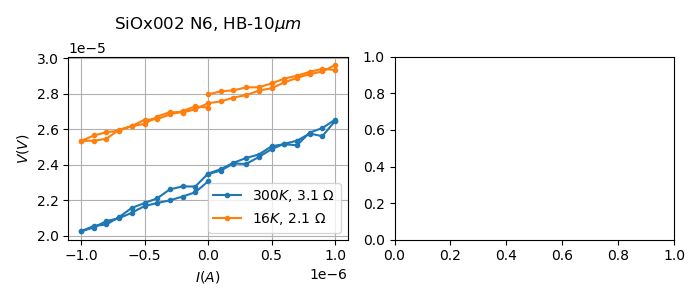

In [260]:
SAMPLE = 'O2N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 12.3e-6, 11.9e-6, 56e-9

labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([4,6]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('SiOx002 N6, HB-$10\mu m$', pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

# labelR = [#'from 300K',
#           'warm up',
#           'cool down, $T_C = 1.95K$']
# for i,v in enumerate([1,2]):
#     data = get_data_by_id(v)
#     T = data[0][0]['data']
#     R = data[0][1]['data']
#     Rs = R*devW/devL
#     ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

# ax[1].legend()
# ax[1].set_xlabel('$T_8 (K)$')
# ax[1].set_ylabel('$R_s (\Omega/sq)$')
# ax[1].set_title('RTc for 6bN8, Hallbar-Dow', pad=20)
# ax[1].set_ylim(-25,175)
# ax[1].grid()
# ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

### $0.7 \times 0.7 \mu m$ junction with $E_J = 190mK$

<IPython.core.display.Javascript object>


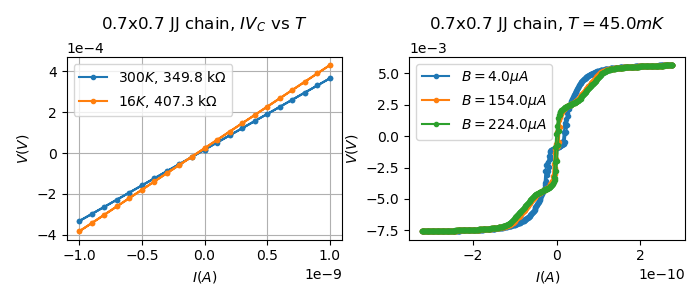

In [246]:
plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([1,2]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('0.7x0.2 JJ chain, $IV_{C}$ vs $T$', pad=20)
ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

T = 0.045
Blst = ex74N3[ex74N3['T'] == T]['B'].tolist()[1]
for i,v in enumerate(ex74N3[ex74N3['T'] == T]['ids'].tolist()[1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    ax[1].plot(Is, Vs, '.',ls='-', label = '$B={}A$'.format(si_format(Blst[i])))

# ax.plot(np.full(10,7.78e-9),np.linspace(Vs.min(),Vs.max(),10),'--', label = '$I_{AB}$')

ax[1].set_xlabel('$I(A)$')
ax[1].set_ylabel('$V(V)$')
ax[1].set_title('0.7x0.2 JJ chain, $T={}K$'.format(si_format(T)), pad=20)
ax[1].grid('both')
ax[1].legend()
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

### $1.5 \times 1.5 \mu m$ junction with $E_J = 2.8K$

<IPython.core.display.Javascript object>


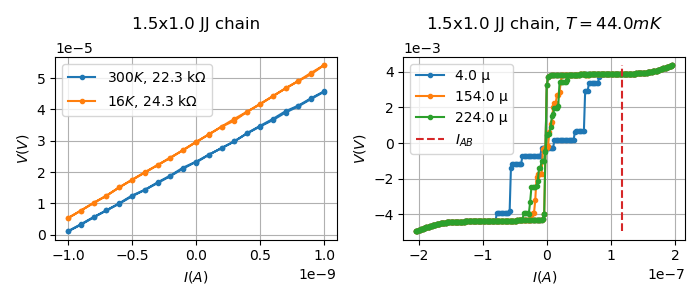

In [258]:
plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 1.51e-6, 17.9e-6, 40e-9

labelL = ['$300K$',
          '$16K$']
for i,v in enumerate([1,2]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('1.5x1.0 JJ chain', pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

T = 44e-3
lst = ex74N4[ex74N4['T'] == T]['ids'].tolist()[0]
Blst = ex74N4[ex74N4['T'] == T]['B'].tolist()[0]
for i,v in enumerate(lst):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    
    Is_off =   2.05e-9
    Vs_off = -6.785e-4
    Is = Is-Is_off
    Vs = Vs-Vs_off
    ax[1].plot(Is, Vs, '.', ls='-', label = '{}'.format(si_format(Blst[i])))
    
ax[1].plot(np.full(10,118e-9),np.linspace(Vs.min(),Vs.max(),10),'--', label = '$I_{AB}$')

ax[1].set_xlabel('$I(A)$')
ax[1].set_ylabel('$V(V)$')
ax[1].set_title('1.5x1.0 JJ chain, $T={}K$'.format(si_format(T)), pad=20)
ax[1].legend()
ax[1].grid('both')
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))


plt.tight_layout()

<IPython.core.display.Javascript object>


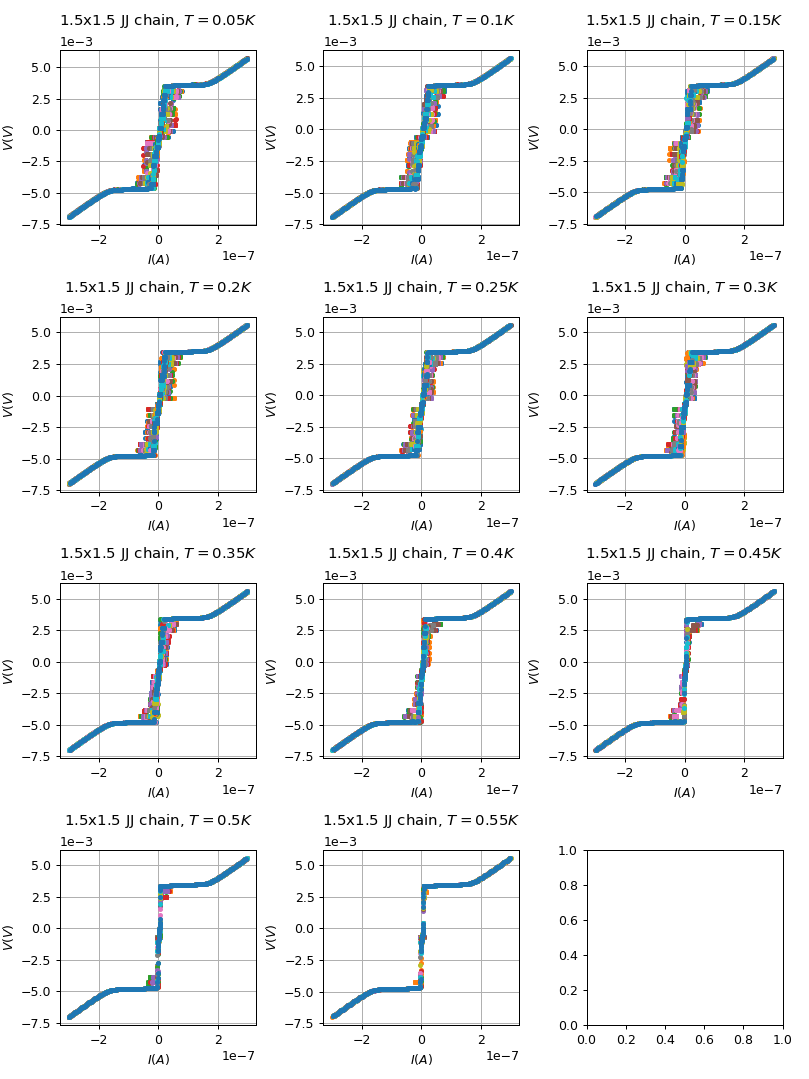

In [108]:
plt.close('all')
f,ax=plt.subplots(4,3, figsize=(9,12))
ax = ax.flatten()

Tlst = [50e-3,100e-3,150e-3,200e-3,250e-3,300e-3,350e-3,400e-3,450e-3,500e-3,550e-3]
for j,T in enumerate(Tlst):
    idlst = ex74N4[ex74N4['T'] == T]['ids'].tolist()[0]
    for i,v in enumerate(idlst):
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']
        ax[j].plot(Is, Vs, '.', label = '$T={}K$'.format(si_format(T)))#ls='-',
    ax[j].grid()
    ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
    ax[j].set_xlabel('$I(A)$')
    ax[j].set_ylabel('$V(V)$')
    ax[j].set_title('1.5x1.5 JJ chain, $T={}K$'.format(T), pad=20)
    ax[j].grid('both')
    ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


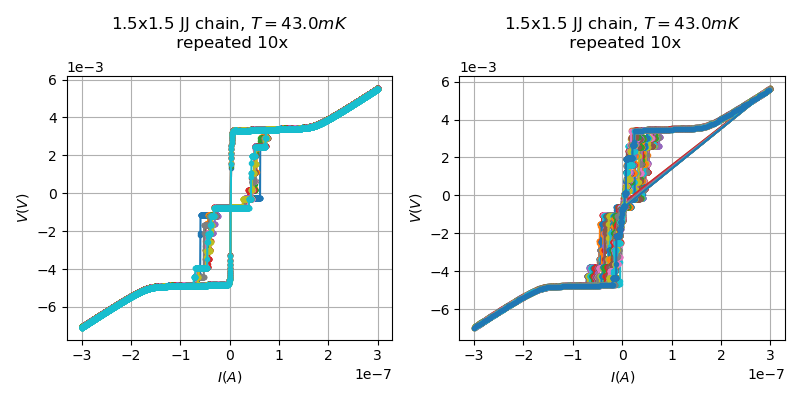

In [281]:
#demonstration about how to plot with multiple lists


plt.close('all')
f,ax=plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()

T = 43e-3
idlst = ex74N4[ex74N4['T'] == T]['ids'].tolist()[-2:]
for j,idl in enumerate(idlst):
    for i,v in enumerate(idl):
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']
        ax[j].plot(Is, Vs, '.',ls='-',label = '$T={}K$'.format(si_format(T)))#alpha=1-0.99*i ,  
        ax[j].set_xlabel('$I(A)$')
        ax[j].set_ylabel('$V(V)$')
        ax[j].set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
        ax[j].grid('both')
        ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


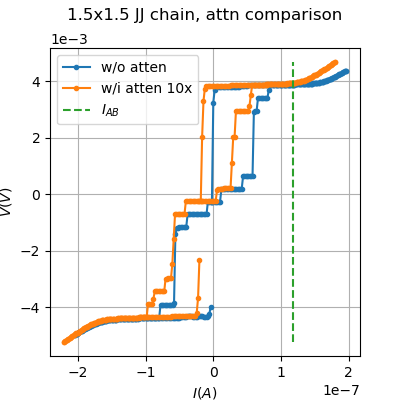

In [267]:
T = 44e-3
lst = ex74N4[ex74N4['T'] == T]['ids'].tolist()
lst = np.asarray(lst)
lst = lst.flatten()
lst = [lst[0],lst[3]]

plt.close('all')
f,ax = plt.subplots(figsize=(4,4))

Blst = ex74N4[ex74N4['T'] == T]['B'].tolist()
Blst = np.asarray(Blst)
Blst = Blst.flatten()
Blst = [Blst[0],Blst[3]]
notelst = ['w/o atten','w/i atten 10x']
for i,v in enumerate(lst):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    
    Is_off =   2.05e-9
    Vs_off = -6.785e-4
    Is = Is-Is_off
    Vs = Vs-Vs_off
    ax.plot(Is, Vs, '.', ls='-', label = '{}'.format(notelst[i]))
    
ax.plot(np.full(10,118e-9),np.linspace(Vs.min(),Vs.max(),10),'--', label = '$I_{AB}$')
ax.legend()
ax.set_xlabel('$I(A)$')
ax.set_ylabel('$V(V)$')
ax.set_title('1.5x1.5 JJ chain, attn comparison', pad=20)
# ax.set_xlim(0,1e-7)
# ax.set_ylim(-4e-4,4e-3)
ax.grid()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))


In [ ]:
plt.close('all')
f,ax=plt.subplots()
# ax = ax.flatten()

T = 43e-3
for i,v in enumerate([275]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    
#     Is_off = 2.25e-9
#     Vs_off = (Vs[20]+Vs[int(len(Is)/2)])/2  
    Is_off = 2.25e-9
    Is_step= 2e-10
    Is = Is-Is_off
    Vs = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2
    
    ax.plot(Is, Vs, '.',ls='-',label = 'raw')
    ax.plot(Is-Is_off, Vs-Vs_off, '.',ls='-',label = 'after centering')
    ax.plot(Is[3], Vs[3], 'X')
    ax.plot(Is[3]-Is_off, Vs[3]-Vs_off, 'X')
    ax.set_xlabel('$I(A)$')
    ax.set_ylabel('$V(V)$')
    ax.set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
    ax.legend()
    ax.grid('both')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [ ]:
plt.close('all')
f,ax = plt.subplots(figsize=(9,9))

for i in [22,40]:
    IVshift = IVc_shift(get_data_by_id(i)[0][0]['data'], 
                    get_data_by_id(i)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)
    
    l = len(IVshift['Is'])
    ax.plot(IVshift['Is'],
            IVshift['Vs'],'.',alpha = 1)
plt.show()

In [ ]:
plt.close('all')
f,ax = plt.subplots(figsize=(9,9))

for i in range(274,283):
    IVshift = IVc_shift(get_data_by_id(i)[0][0]['data'], 
                    get_data_by_id(i)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)

    l = len(IVshift['Is'])
    ax.plot(IVshift['Is'][int(l/64):int(l/14)],
            IVshift['Vs'][int(l/64):int(l/14)],'-',alpha = 1)
plt.show()

In [ ]:
def IVc_shift (Is, Vs, Is_off = 2.25e-9, Is_step= 2e-10):
    Is1 = Is-Is_off
    Vs1 = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2

    IVs = pd.DataFrame(data = zip(Is1,Vs1), columns = ['Is', 'Vs'])
    
    ofsInd = int(np.floor(np.abs(IVs['Is'][0])/Is_step))+1
    IVs_shift = IVs.shift(periods=-1*ofsInd)
    IVs_shift = pd.concat([IVs_shift[:-1*ofsInd], IVs[0:ofsInd]], ignore_index=True)
    maxInd = IVs_shift[IVs_shift['Is'] == IVs_shift['Is'].max()].index[0]+1
    IVs_shift = pd.concat([IVs_shift[:3*maxInd], IVs_shift[-1*maxInd-1:]])
    return IVs_shift

In [ ]:
IVshift = IVc_shift(get_data_by_id(279)[0][0]['data'], 
                    get_data_by_id(279)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)

plt.close('all')
f,ax = plt.subplots()
l = len(IVshift['Is'])

for i in [0,1,2,3]:
    ax.plot(IVshift['Is'][int(l*i/4):int(l*(i+1)/4)],
            IVshift['Vs'][int(l*i/4):int(l*(i+1)/4)],'-',alpha = 0.5)
plt.show()

In [ ]:
plt.close('all')
f,ax = plt.subplots()

data = get_data_by_id(275)
Is = data[0][0]['data']
Vs = data[0][1]['data']
Is_off = 2.25e-9
Is_step= 2e-10
Vs_off = (Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2
Is1 = Is-Is_off
Vs1 = Vs-Vs_off
# ax.plot(Is1[int(len(Is1)/4*0):int(len(Is1)/4*4)],
#         Vs1[int(len(Vs1)/4*0):int(len(Vs1)/4*4)])

IVs = pd.DataFrame(data = zip(Is1,Vs1), columns = ['Is', 'Vs'])
ofsInd = int(np.floor(np.abs(IVs['Is'][0])/np.round((IVs['Is'][1]-IVs['Is'][0]),15)))+1
IVs_shift = IVs.shift(periods=-1*ofsInd)
IVs_shift = pd.concat([IVs_shift[:-1*ofsInd], IVs[0:ofsInd]], ignore_index=True)

maxInd = IVs_shift[IVs_shift['Is'] == IVs_shift['Is'].max()].index[1]
IVs_shift = pd.concat([IVs_shift[:3*maxInd], IVs_shift[-1*maxInd:]])

l = len(IVs_shift)
for i in [0,1,2,3]:
    ax.plot(IVs_shift['Is'][int(l*i/4):int(l*(i+1)/4)],
            IVs_shift['Vs'][int(l*i/4):int(l*(i+1)/4)],'x',alpha = 0.5)
plt.show()

## Brief summary